<a href="https://colab.research.google.com/github/WiMean/Yandex_Praktikum/blob/main/Prefab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор изображений по запросу

---

**Цель**

Разработать демонстрационную версию поиска изображений по запросу.  
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

---

**Исходные данные**

Набор пар "изображение-описание" с оценками от экспертов и пользователей, набор файлов с изображениями и тексты описаний.

---

**Задачи:**  

- провести исследовательский анализ данных;
- вывести агрегированную оценку на основе экспертных и пользовательских оценок для каждой пары "изображение-описание";
- удалить из обучающего набора изображения, нарушающие требования законодательства (изображения с детьми);
- выполнить векторизацию данных обучающего набора (изображений, текстов, затем объединить их);
- в качестве бейзлайна обучить модель;
- обучить модель на базе нейронной сети (нейросеть);
- проверить модель-нейросеть на тестовых данных;
- сформулировать рекомендации для дальнейшего развития проекта.

In [47]:
#!pip install transformers
#!pip install opencv-python
#!pip install sentence-transformers
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.4 MB/s eta 0:00:00


In [5]:
# Импортируем необходимые библиотеки

import os
import pandas as pd
import numpy as np
import re
import pickle
import tensorflow as tf
import warnings
import time

from pathlib import Path
import pandas as pd
import requests

from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()
from PIL import Image
import cv2

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

import matplotlib.image as mpimg

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

In [6]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
RS = 42

In [8]:
#Скачивание файлов в рабочее окружение
!wget -N https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -uq dsplus_integrated_project_4.zip
print('-' * 100)
!ls

--2023-09-15 10:03:58--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  22.8MB/s    in 7.1s    

2023-09-15 10:04:06 (20.2 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]

----------------------------------------------------------------------------------------------------
dsplus_integrated_project_4.zip  __MACOSX  sample_data	to_upload


In [9]:
#Проверка рабочей области
print (os.getcwd())

/content


In [10]:
PATH_SWITCH = 'local'
#Фиксация пути к файлам
PATH = '/content/to_upload/'
PATH_REMOTE = '/to_upload/'

PATH_IMAGE_TRAIN = PATH + 'train_images/'
PATH_IMAGE_TEST = PATH + 'test_images/'

In [11]:
def read_df(path=PATH) -> pd.DataFrame:

    '''читаем датафреймы из указанной директории'''

    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))#.sample(frac=0.1)
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')

    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

In [12]:
PATH_IMAGE_TEST

'/content/to_upload/test_images/'

In [13]:
display(df_train.sample(5),
        df_crowd.head(),
        df_expert.head(),
        df_queries.sample(5),
        df_images.sample(5),
        df_train.describe())

,image,query_id,query_text
1702,3159995270_17334ccb5b.jpg,3245070961_8977fdd548.jpg#2,A little boy in navy blue is running very fast .
539,3099923914_fd450f6d51.jpg,3591458156_f1a9a33918.jpg#2,A man at a rodeo is thrown off a horse .
463,700884207_d3ec546494.jpg,3516825206_5750824874.jpg#2,"Laying on stones , a girl with messy hair has ..."
1209,2689001252_e0016c89f0.jpg,2892995070_39f3c9a56e.jpg#2,A brown dog leaps into the air next to a black...
2598,150387174_24825cf871.jpg,498444334_a680d318a1.jpg#2,Five young men pose on the steps .


,image,query_id,share_pos,count_pos,count_neg
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


,image,query_id,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


,query_id,query_text,image
471,862156271_3eacea90a8.jpg#1,two girls walking in the street,862156271_3eacea90a8.jpg
171,2737233999_34d60dc5c3.jpg#1,Four people are playing basketball on a plank ...,2737233999_34d60dc5c3.jpg
28,1468389504_c724bdcad0.jpg#3,Two young girls on a playground .,1468389504_c724bdcad0.jpg
482,957682378_46c3b07bcd.jpg#2,A dark black dog is playing with a light brown...,957682378_46c3b07bcd.jpg
155,269650644_059a84ece5.jpg#0,A group of people are ice skating in a big city .,269650644_059a84ece5.jpg


,image
65,3122579598_14841c038a.jpg
3,1429546659_44cb09cbe2.jpg
43,3459871361_92d1ecda36.jpg
21,3330333217_1a69497a74.jpg
98,2670637584_d96efb8afa.jpg


,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Как видно из таблицы, в тренировочном датасете у нас 100 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

In [14]:
#Агрегирующая функция для DF data_expert
def agr_data(row):

    # Если оценки экспертов не равны друг другу, берём среднее
    if row['first'] != row['second'] != row['third']:
        row['agr_expert'] = (row['first'] + row['second'] + row['third']) // 3
    # В любом другом случае медиана
    else:
        row['agr_expert'] = int(np.median(row['first':'third']))

    return row

df_expert = df_expert.progress_apply(agr_data, axis=1)
df_expert

100%|██████████| 5822/5822 [00:06<00:00, 891.63it/s] 


,image,query_id,first,second,third,agr_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


In [15]:
df_expert.isna().mean()

image         0.0
query_id      0.0
first         0.0
second        0.0
third         0.0
agr_expert    0.0
dtype: float64

In [16]:
df_expert.shape

(5822, 6)

In [17]:
agr_expert_unique = df_expert.agr_expert.unique()
agr_expert_unique

array([1, 2, 3, 4])

Для объединения оценок экспертов и краудсорсинговых оценок используем следующий алгоритм:
1) Если для сочетания изображения и текста отсутствует только одна из двух оценок, выбираем оценку, которая доступна.
2) Если имеются обе оценки, мы обращаем внимание на краудсорсинговую оценку.

Если более половины участников голосования считают, что текст не соответствует изображению, мы уменьшаем оценку на один "экспертный" голос.
Если более половины участников считают, что текст соответствует, мы увеличиваем оценку на один пункт.

Учтите, что один голос эксперта эквивалентен  
1
9
  оценки.

3) Оценка не может быть больше 1 или меньше 0

In [18]:
#Функция аггрегации оценок аутсорса и экспертов
df_merged = df_expert.merge(df_crowd, on = ['image', 'query_id'], how='outer')

def score_aggregate(row) -> object:

    if np.isnan(row['agr_expert']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['agr_expert']
    else:
        row['score'] = row['agr_expert'] * 0.7 + row['share_pos'] * 0.3

    return row

df_merged = df_merged.progress_apply(score_aggregate, axis=1)
df_merged

100%|██████████| 51323/51323 [00:41<00:00, 1246.60it/s]


,image,query_id,first,second,third,agr_expert,share_pos,count_pos,count_neg,score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,1.0,0.000000,0.0,3.0,0.700000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,1.0,2.0,1.0,0.000000,0.0,3.0,0.700000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,1.0,2.0,1.0,NaN,NaN,NaN,1.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.0,2.0,2.0,2.0,NaN,NaN,NaN,2.000000
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,1.0,2.0,1.0,NaN,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...
51318,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
51319,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,NaN,NaN,NaN,NaN,0.333333,1.0,2.0,0.333333
51320,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,NaN,NaN,NaN,NaN,1.000000,3.0,0.0,1.000000
51321,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000


In [19]:
display('Количество пропусков score', df_merged['score'].isna().mean(),
        df_merged['score'].describe())

'Количество пропусков score'

0.0

count    51323.000000
mean         0.212101
std          0.504731
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: score, dtype: float64

In [20]:
df_train = pd.merge(df_train, df_merged[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [21]:
df_train['query_text'].isna().value_counts()

True     45501
False     5822
Name: query_text, dtype: int64

In [22]:
filling = df_train[df_train['query_text'].notna()]

In [23]:
#Функция заполнения пропусков в описаниях к фото
def fill_text(row) -> object:

    if pd.isnull(row['query_text']):
        texts = filling[filling['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

df_train = df_train.progress_apply(fill_text, axis=1)

100%|██████████| 51323/51323 [00:56<00:00, 908.08it/s]


In [24]:
df_train['query_text'].isna().value_counts()

False    50214
True      1109
Name: query_text, dtype: int64

In [25]:
df_train.dropna(inplace=True)

In [26]:
df_train['query_text'].value_counts()

Two white dogs running                                                               176
A white dog is running on gravel away from two people and a black and brown dog .    152
Two children look up .                                                               152
two dogs play together .                                                             144
Two dogs are jumping up at each other .                                              141
                                                                                    ... 
Kid guards face from soccer ball                                                      13
A smaller art festival on the edge of a forest                                        11
a woman enjoying her reading at a coffee shop                                         10
People are inspecting sound equipment indoors .                                       10
Some teenagers are scrambling for a basketball underneath the net .                    9
Name: query_text, Len

In [27]:
df_train['image'].value_counts()

1572532018_64c030c974.jpg    118
3250695024_93e8ab7305.jpg    111
3359551687_68f2f0212a.jpg    102
324208502_674488bcea.jpg     101
2239938351_43c73c887c.jpg    100
                            ... 
3567061016_62768dcce1.jpg     15
363617160_6cb0c723be.jpg      15
3578841731_f775cab089.jpg     14
2295750198_6d152d7ceb.jpg     14
2914206497_5e36ac6324.jpg     10
Name: image, Length: 1000, dtype: int64

In [28]:
mm_scaler = MinMaxScaler()

In [29]:
df_train['score'] = mm_scaler.fit_transform(df_train[['score']])

In [30]:
df_train.sample(10)

,image,query_id,query_text,score
21703,2693425189_47740c22ed.jpg,1517721825_10176d0683.jpg#2,Three dogs running through water .,0.000000
40195,3518126579_e70e0cbb2b.jpg,2910758605_73a3f5a5c2.jpg#2,A man carries a child while he walks with a wo...,0.000000
9965,1765164972_92dac06fa9.jpg,491405109_798222cfd0.jpg#2,A small girl is doing a handstand while smiling,0.000000
43471,3630641436_8f9ac5b9b2.jpg,3462454965_a481809cea.jpg#2,"Three black dogs , two with tan markings , are...",0.000000
29397,311146855_0b65fdb169.jpg,3655964639_21e76383d0.jpg#2,The woman wearing a red bow walks past a bicyc...,0.000000
9534,1626754053_81126b67b6.jpg,416106657_cab2a107a5.jpg#2,"A white dog runs in the grass ,",0.083333
38348,3457045393_2bbbb4e941.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.000000
22146,2715035273_8fc8b1291c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000
3300,3107513635_fe8a21f148.jpg,138718600_f430ebca17.jpg#2,Two girls are sitting on a path by a river wit...,0.250000
40460,352382023_7605223d1c.jpg,1674612291_7154c5ab61.jpg#2,A dog jumps and catches a toy .,0.000000


In [31]:
df_train['score'].describe()

count    50214.000000
mean         0.053998
std          0.127267
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

In [32]:
BLOCK_WORDS = [
    'boy',
    'boys',
    'girl',
    'girls',
    'child',
    'baby',
    'kid',
    'babe',
    'infant',
    'teenager',
    'teenage',
    'teeny',
    'juvenile',
    'teener',
    'young',
    'younger',
    'youngest',
    'youngster',
    'stripling',
    'schoolchild',
    'schoolboy',
    'schoolgirl']

In [33]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:

    '''очищаем текст и превращаем в список лемм'''

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова

    return text

def cleaning(row) -> object:

    '''отмечаем тексты для блокирования'''

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK_WORDS]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [34]:
%time df_train = df_train.progress_apply(cleaning, axis=1)

100%|██████████| 50214/50214 [00:54<00:00, 920.69it/s]

CPU times: user 53.1 s, sys: 446 ms, total: 53.6 s
Wall time: 54.5 s


In [35]:
print(df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique())

['A teenage boy climbs an indoor climbing wall .'
 'Two girls are dressed the same and one of them is playing with a toy lawnmower .'
 'A young boy is riding a bike .'
 'A little boy in a purple shirt and blue shorts playing with orange balls .'
 'a young man wearing dark sunglasses smiling'
 'A little boy is jumping out of the pool .'
 'A boy is on the beach with a paddle in his hand as he walks through the ocean water .'
 'A young girl jumping over a railing or a ladder on its side .'
 'A young man attempts to ride a unicycle down an outdoor stairway stained with moss .']


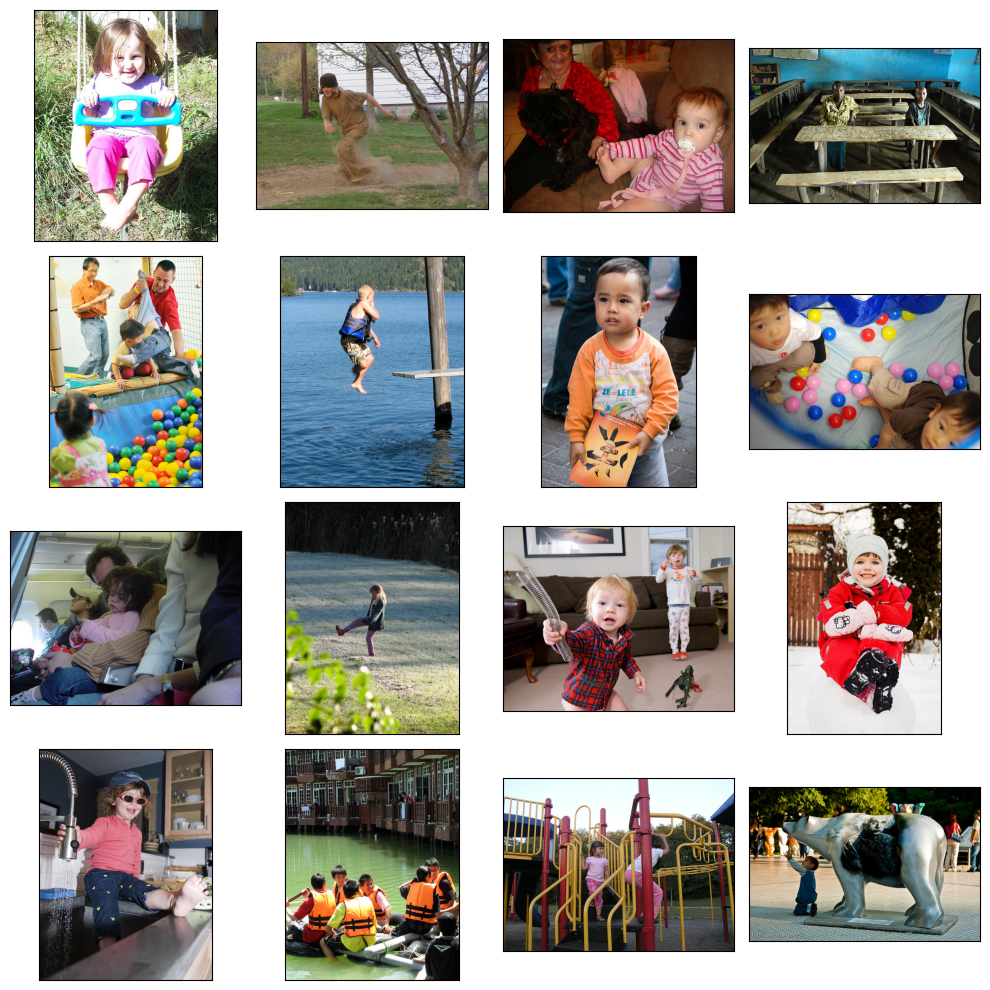

In [36]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [37]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

In [38]:
display(df_train.head(), df_queries.head())
df_train.info()
print('-' * 100)
df_queries.info()

,image,query_id,query_text,score
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.25
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.50
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.35
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.50
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.25


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35551 entries, 0 to 35550
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       35551 non-null  object 
 1   query_id    35551 non-null  object 
 2   query_text  35551 non-null  object 
 3   score       35551 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


# Векторизация изображений

# Необходимо будет изменить качество картинки с 48 на 192

In [39]:
def load_train(path=PATH) -> ImageDataGenerator:

    '''загрузчик данных для обучения'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(PATH_IMAGE_TRAIN),
        x_col='image',
        y_col='score',
        target_size=(48, 48),
        batch_size=16,
        class_mode='input',
        seed=RS)

    return train_gen_flow

Проверим выдачу полученного генератора.

Found 35551 validated image filenames.


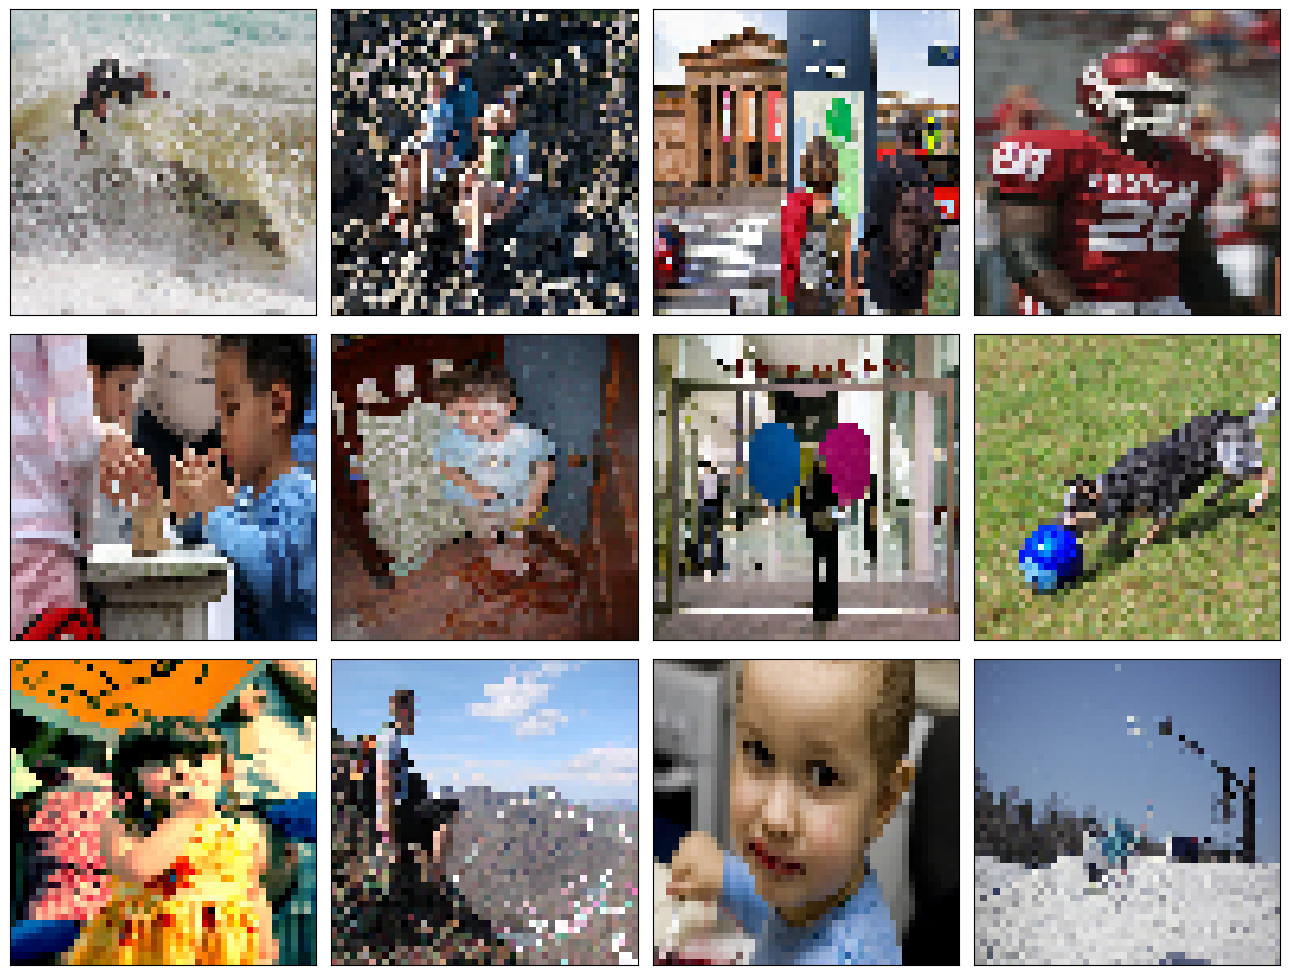

In [40]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Все нормально.
В набор не попали фото с детьми

Объявим модель.

In [41]:
# В модель добавил .to(device) необходимо проверить работоспособность, чтобы код успешно работал и на GPU и на CPU
def create_model(input_shape=(96, 96, 3)):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [42]:
#Функция векторизации изображений
def vectorize_pictures(model, df_train):

    predictions = model.predict(df_train)

    return predictions

In [43]:
%%time

pict_embeds = vectorize_pictures(create_model(), load_train())

94765736/94765736 [==============================] - 1s 0us/step
Found 35551 validated image filenames.
2222/2222 [==============================] - 504s 226ms/step
CPU times: user 12min 41s, sys: 17.2 s, total: 12min 58s
Wall time: 9min 27s


In [44]:
with open('pict_embeds.pickle', 'wb') as f:
    pickle.dump(pict_embeds, f)
None

In [ ]:
with open('img_embend.pickle', 'rb') as f:
    pict_embeds = pickle.load(f)
None

In [45]:
pict_embeds.shape

(35551, 2048)

# Векторизация текстов

In [48]:
import keras_nlp

Using TensorFlow backend


In [49]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

433474808/433474808 [==============================] - 6s 0us/step


In [50]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

213450/213450 [==============================] - 0s 0us/step


In [68]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:
    '''преобразуем тексты в словарь токенов, масок и паддингов'''
    embeddings = []
    tokenized = preprocessor(data)

    token_ids = tokenized['token_ids']
    segment_ids = tokenized['segment_ids']
    padding_mask = tokenized['padding_mask']
    dataset = tf.data.Dataset.from_tensor_slices((token_ids, segment_ids, padding_mask))
    dataset = dataset.batch(batch_size)

    for tokens, token_types, mask in tqdm(dataset):
        batch = {'token_ids': tokens,
                 'segment_ids': token_types,
                 'padding_mask': mask}

        batch_embeddings = model.predict(batch, verbose=0)
        embeddings.append(batch_embeddings['pooled_output'])

    return tf.concat(embeddings, axis=0)

In [69]:
text = list(df_train['query_text'])

In [ ]:
%%time

text_embeds = vectorize_text(model=bert, data=text, batch_size=64, verbose=1)

  0%|          | 1/556 [02:54<26:56:11, 174.72s/it]

In [ ]:
with open('text_embeds.pickle', 'wb') as f:
    pickle.dump(text_embeds, f)
None

In [ ]:
with open('text_embeds.pickle', 'rb') as f:
    text_embeds = pickle.load(f)
None

In [ ]:
text_embeds

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
1,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
2,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
3,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
4,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35976,-0.828754,0.493281,2.502946,1.331367,1.111631,1.215286,-0.365967,0.380763,0.943415,-0.297641,...,1.339196,-0.796218,0.970458,-0.174035,0.530890,-2.155522,0.744911,-0.158184,-0.674521,0.952203
35977,-0.829656,0.744043,2.591155,1.714685,0.983593,1.059513,-0.100701,0.220011,0.623236,-0.797183,...,1.022983,-0.829982,1.094782,-0.435351,0.380970,-2.123763,0.748888,-0.149845,-0.354057,0.792276
35978,-1.053747,0.849904,2.815745,1.416617,1.516324,1.641608,-0.137453,-0.078914,0.423025,-0.319508,...,1.195611,-0.763699,1.248260,-0.270192,0.320671,-2.342497,0.422272,0.098908,-0.230243,0.772776
35979,-0.836550,1.140922,2.774887,1.777277,1.752044,1.582449,-0.512929,0.113791,0.659669,-0.623722,...,1.400859,-0.657171,1.223300,-0.290585,0.544579,-2.053350,0.348718,-0.009683,-0.204353,1.145436


In [ ]:
text_embeds.shape

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
1,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
2,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
3,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
4,-0.987833,0.673303,2.721748,1.265375,1.239629,1.361470,-0.254034,-0.182506,0.504412,-0.342732,...,1.039769,-0.857855,1.568307,-0.107012,0.545149,-2.523912,0.758081,0.097727,-0.134123,0.722528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35976,-0.828754,0.493281,2.502946,1.331367,1.111631,1.215286,-0.365967,0.380763,0.943415,-0.297641,...,1.339196,-0.796218,0.970458,-0.174035,0.530890,-2.155522,0.744911,-0.158184,-0.674521,0.952203
35977,-0.829656,0.744043,2.591155,1.714685,0.983593,1.059513,-0.100701,0.220011,0.623236,-0.797183,...,1.022983,-0.829982,1.094782,-0.435351,0.380970,-2.123763,0.748888,-0.149845,-0.354057,0.792276
35978,-1.053747,0.849904,2.815745,1.416617,1.516324,1.641608,-0.137453,-0.078914,0.423025,-0.319508,...,1.195611,-0.763699,1.248260,-0.270192,0.320671,-2.342497,0.422272,0.098908,-0.230243,0.772776
35979,-0.836550,1.140922,2.774887,1.777277,1.752044,1.582449,-0.512929,0.113791,0.659669,-0.623722,...,1.400859,-0.657171,1.223300,-0.290585,0.544579,-2.053350,0.348718,-0.009683,-0.204353,1.145436


# Подготовка признаков

In [ ]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(35981, 2816)

In [ ]:
y = np.array(df_train['score'])
y.shape

(35551,)

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RS)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

ValueError: Found input variables with inconsistent numbers of samples: [35981, 35551, 35551]

In [ ]:
X_train, X_test = X[train_indices], X[test_indices]

(35981,)

In [ ]:
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

(35981,)

In [ ]:
#baseline model

model_r = Ridge().fit(X_train, y_train)
predictions = model_r.predict(X_test)
np.sqrt(np.sqrt(mean_squared_error(y_test, predictions)))

14.850355937286896

# Построение базовой нейронной сети

Проблемка со скэйлером, надо решить этот вопрос, вполне вероятно его позже делать необходимо

In [ ]:
NN = Sequential()
NN.add(Dense(2816, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

In [ ]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

In [ ]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=30, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=30, num_workers=0)

# Тестирование нейронной сети

In [ ]:
def load_test(path=PATH) -> ImageDataGenerator:

    '''загрузчик данных для тестирования'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)

    return train_gen_flow

In [ ]:
%%time

pict_embeds_test = vectorize_pictures(create_model(), load_test())
pict_embeds_test.shape

2023-09-15 12:22:54.639930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 12:22:54.640835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 100 validated image filenames.


2023-09-15 12:22:59.549531: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-15 12:22:59.947530: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-15 12:23:00.128174: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276889600 exceeds 10% of free system memory.
2023-09-15 12:23:00.275605: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-15 12:23:00.460720: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


2/2 [==============================] - 15s 4s/step


(100, 2048)

In [ ]:
def get_picture(text) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''

    if [i for i in get_lemmas(text) if i in BLOCK_WORDS]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False) #получаем эмбеддинг текста
        X = np.concatenate(( #объединяем вектора тестовых картинок с эмбеддингом текста
            pict_embeds_test,
            np.resize(text_embed, (pict_embeds_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = NN.predict(X) #получаем предсказания оценок экспертов
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) #получили топ 5 имён файлов с картинками
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) #получили топ 5 оценок

        print('')
        print('-' * 20, text, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

In [ ]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A blonde girl in a black cape stands with other children in costumes .',
 'A little girl leans over the side of a wall to feed ducks in the water .',
 'Young children play in the sprinkler .',
 'Two white dogs chase after a red ball in a yard in front of a white fence .',
 'People are watching a skier perform a trick in the air .']

In [ ]:
for text in text_test:
    get_picture(text)


-------------------- A blonde girl in a black cape stands with other children in costumes . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A little girl leans over the side of a wall to feed ducks in the water . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- Young children play in the sprinkler . --------------------

This image is unavailable in your country in compliance with local laws.



TypeError: vectorize_text_with_bert() got an unexpected keyword argument 'model'

# Тестирование нейронной сети CLIP

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

In [ ]:
def search(query) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''

    if [i for i in lemmatize_text(query) if i in BLOCK_WORDS]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, query, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False) #получаем эмбеддинг запроса
        # Используем функцию util.semantic_search, которая вычисляет косинусную схожесть
        # между эмбеддингом запроса и всеми картинками из базы.
        # Далее функция возвращает top_k картинок с наивысшим рейтингом
        hits = util.semantic_search(query_emb, img_emb, top_k=5)[0]
        print('')
        print('-' * 20, query, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(hits[i]['score'], 2))
            image = Image.open(img_names[hits[i]['corpus_id']])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if query in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == query].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

In [ ]:
samples = df_queries.sample(5)
queries = list(samples['query_text'])
queries

['Three women are looking into a camera .',
 'A group of children dressed for halloween stand in line with the exception of one girl .',
 'Children in costumes standing in line .',
 'One person snowboarding while others look on .',
 'Young children play in the sprinkler .']

In [ ]:
for query in queries:
    search(query)

NameError: name 'search' is not defined